# Problem Statement


## Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

## Understanding the Business Objective and the Data
The dataset contains customer-level information for a span of four consecutive months - June, July, August and September. The months are encoded as 6, 7, 8 and 9, respectively. 


The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months. To do this task well, understanding the typical customer behaviour during churn will be helpful.

## Understanding Customer Behaviour During Churn
Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# Imports & Data Loading

In [264]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier    
import time

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Read the data
cust = pd.read_csv("data/telecom_churn_data.csv")

In [5]:
cust.shape

(99999, 226)

In [6]:
cust.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [7]:
# Smaller file to manually check on the first 10 records in the dataset
cust.head(10).T.to_csv("sample_10_T.csv")

In [8]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# Utility Methods

## Check for missing values in a dataframe

In [9]:
# Check for missing values in the dataframe and print them
def print_missing_columns(input_df):
    # Print missing percentage of only columns with missing values
    missing_columns = input_df.columns[input_df.isnull().any()]
    if not missing_columns.empty:
        missing_count = input_df[missing_columns].isnull().sum()
        missing_col_type = pd.Series([type(col) for col in input_df[missing_columns]],index = missing_columns) 
        unique_count = input_df[missing_columns].nunique()

        missing_df = pd.concat({
                        "Missing": missing_count, 
                        "Missing %": missing_count/len(input_df.index)*100,
                        "Type": missing_col_type,
                        "Unique Count": unique_count
                       } , 
                       axis = 1).sort_values(by = 'Missing', ascending = False)

        display(missing_df)
    else:
        display("NO MISSING VALUES IN THE DATAFRAME")

# Data Preprocessing

## Check for missing data

In [10]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
count_rech_2g_6,74846,74.846748,<class 'str'>,31
max_rech_data_6,74846,74.846748,<class 'str'>,48
arpu_3g_6,74846,74.846748,<class 'str'>,7418
av_rech_amt_data_6,74846,74.846748,<class 'str'>,887
count_rech_3g_6,74846,74.846748,<class 'str'>,25
night_pck_user_6,74846,74.846748,<class 'str'>,2
arpu_2g_6,74846,74.846748,<class 'str'>,6990
fb_user_6,74846,74.846748,<class 'str'>,2
total_rech_data_6,74846,74.846748,<class 'str'>,37
date_of_last_rech_data_6,74846,74.846748,<class 'str'>,30


## Handle missing data

### Replace missing with 0
Missing 'incoming' & 'outgoing' call related columns can be set to 0 assuming there were no calls received/made for that column type

In [11]:
cust.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [12]:
# Incoming calls column:
# All columns with incoming call information have the string "ic_" in the column name
# Fill the missing values in these columns with 0
incoming_cols = [col for col in cust.columns if 'ic_' in col]
cust[incoming_cols] = cust[incoming_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(incoming_cols)} incoming columns:{incoming_cols}')

# Outgoing calls column:
# All columns with outgoing call information have the string "og_" in the column name
# Fill the missing values in these columns with 0
outcoming_cols = [col for col in cust.columns if 'og_' in col]
cust[outcoming_cols] = cust[outcoming_cols].fillna(0)
print(f'\nReplaced missing values with 0 for {len(outcoming_cols)} outgoing columns:{outcoming_cols}')

Replaced missing values with 0 for 57 incoming columns:['loc_ic_t2o_mou', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_ic_mou_9', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_t2f_mou_9', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'loc_ic_mou_9', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8', 'std_ic_mou_9', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_ic_mou_9', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7', 'i

In [13]:
# Recharge related columns
rech_cols = [col for col in cust.columns if re.match('^count_rech_|^max_rech_|^total_rech_|^av_rech_', col)]
cust[rech_cols] = cust[rech_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(rech_cols)} recharge columns :{rech_cols}')

Replaced missing values with 0 for 32 recharge columns :['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']


In [14]:
# OFFNET/ONNET MOU related columns
mou_cols = [col for col in cust.columns if re.match('^onnet_mou|^offnet_mou', col)]
cust[mou_cols] = cust[mou_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(mou_cols)} OFFNET/ONNET MOU columns :{mou_cols}')

Replaced missing values with 0 for 8 OFFNET/ONNET MOU columns :['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9']


In [15]:
# arpu related columns
arpu_cols = [col for col in cust.columns if re.match('^arpu', col)]
cust[arpu_cols] = cust[arpu_cols].fillna(0)
print(f'Replaced missing values with 0 for {len(arpu_cols)} arpu columns :{arpu_cols}')

Replaced missing values with 0 for 12 arpu columns :['arpu_6', 'arpu_7', 'arpu_8', 'arpu_9', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8', 'arpu_2g_9']


### Handle date columns

-- Last recharges made for talktime and data for each month is provided <br>
-- Combine the columns for the good phase & action phase and get the last date when a recharge was made <br>
-- At the beginning of 9th month, get the number of days since the last recharge <br>
-- Hypothesis - if the customer has done a recharge recently, they are less likely to churn.  <br>

In [16]:
print(f'Shape before handling date columns:{cust.shape}')

Shape before handling date columns:(99999, 226)


In [17]:
# Change data type of date columns to datetime
date_cols = [col for col in cust.columns if re.match('^date|^last_date', col)]
cust[date_cols] = cust[date_cols].apply(pd.to_datetime,errors='coerce') 

In [18]:
date_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_9',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'date_of_last_rech_data_9']

In [19]:
cust[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']].tail()

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8
99994,2014-06-03,2014-07-20,2014-08-26
99995,2014-06-17,2014-07-17,2014-08-24
99996,2014-06-13,2014-07-26,NaT
99997,2014-06-17,2014-07-19,2014-08-20
99998,2014-06-16,NaT,NaT


In [20]:
cust[date_cols].max()

last_date_of_month_6       2014-06-30
last_date_of_month_7       2014-07-31
last_date_of_month_8       2014-08-31
last_date_of_month_9       2014-09-30
date_of_last_rech_6        2014-06-30
date_of_last_rech_7        2014-07-31
date_of_last_rech_8        2014-08-31
date_of_last_rech_9        2014-09-30
date_of_last_rech_data_6   2014-06-30
date_of_last_rech_data_7   2014-07-31
date_of_last_rech_data_8   2014-08-31
date_of_last_rech_data_9   2014-09-30
dtype: datetime64[ns]

In [21]:
# Find the last recharge date in the good phase & action phase (gaphase) together (Months 6,7,8)
last_rech_date_cols = [col for col in cust.columns if re.match('^date_of_last_.*[_6|_7|_8]$', col)]
cust['last_rech_date_gaphase'] = cust[last_rech_date_cols].apply(lambda x: x.max(),axis=1)

In [22]:
# Check for missing values
cust['last_rech_date_gaphase'].isnull().sum()

99

In [23]:
# Missing values in this new column implies no recharge has happend in the 3 months.
# Fill missing value with last date of previous month before the start of good phase
last_rech_date_missing = datetime.datetime(2014, 5, 31)
cust['last_rech_date_gaphase']=cust['last_rech_date_gaphase'].fillna(last_rech_date_missing)

In [24]:
# Create column for number of  days since last recharge
last_date_action_phase = datetime.datetime(2014, 8, 31)
cust['last_rech_num_days'] = (last_date_action_phase - cust['last_rech_date_gaphase']).dt.days

In [25]:
cust[['last_rech_date_gaphase','last_rech_num_days']].head()

,last_rech_date_gaphase,last_rech_num_days
0,2014-08-08,23
1,2014-08-28,3
2,2014-08-14,17
3,2014-08-31,0
4,2014-08-09,22


In [26]:
# drop date columns after creating the days columns
print(f'Shape before dropping date columns:{cust.shape}')
cust.drop(date_cols,inplace=True,axis=1)
cust.drop('last_rech_date_gaphase',inplace=True,axis=1)
print(f'Shape after dropping date columns:{cust.shape}')

Shape before dropping date columns:(99999, 228)
Shape after dropping date columns:(99999, 215)


In [27]:
print_missing_columns(cust)

,Missing,Missing %,Type,Unique Count
night_pck_user_6,74846,74.846748,<class 'str'>,2
fb_user_6,74846,74.846748,<class 'str'>,2
night_pck_user_7,74428,74.428744,<class 'str'>,2
fb_user_7,74428,74.428744,<class 'str'>,2
night_pck_user_9,74077,74.077741,<class 'str'>,2
fb_user_9,74077,74.077741,<class 'str'>,2
night_pck_user_8,73660,73.660737,<class 'str'>,2
fb_user_8,73660,73.660737,<class 'str'>,2


### IterativeImputer

In [28]:
# # Use fancy imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
# from fancyimpute import KNN
# knn_imputer = KNN()
# # imputing the missing value with knn imputer
# cust = knn_imputer.fit_transform(cust)
#
# Unable to install fancyimpute with pip install due to dependent version mismatches in local system.

In [29]:
# Use iterative imputer to fill the rest of the missing colums (fb_user_* and night_pck_user_* columns)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iter_imputer = IterativeImputer()

fb_night_cols = [col for col in cust.columns if re.match('^fb_user_|^night_pck_user_', col)]

cust[fb_night_cols] = iter_imputer.fit_transform(cust[fb_night_cols])

In [30]:
print_missing_columns(cust)

'NO MISSING VALUES IN THE DATAFRAME'

## <TODO> Check data types

In [31]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 215 entries, mobile_number to last_rech_num_days
dtypes: float64(179), int64(36)
memory usage: 164.0 MB


## <TODO> Check for outliers

## Remove columns with only one unique value. 
Columns with only one unique value will not add much value to the analysis and can be removed

In [32]:
cust = cust[[col for col in cust.columns if cust[col].nunique() > 1]]


## Drop ID column - mobile_number

In [33]:
cust.drop(['mobile_number'],axis=1,inplace=True)

In [34]:
cust.shape

(99999, 202)

# Target Variable Creation

## Create Target variable from 9th Month

Create the target variable based on the below rule:
 
Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9,
total_og_mou_9,
vol_2g_mb_9,
vol_3g_mb_9

In [35]:
# Create churn flag based on the 9th month variables. 
cust['churn'] = (cust['total_ic_mou_9']+cust['total_og_mou_9']+cust['vol_2g_mb_9']+cust['vol_3g_mb_9']) == 0
cust['churn']=cust['churn'].map({True:1,False:0})

In [36]:
cust['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

## Remove 9th month variables

In [37]:
# drop the columns with the suffix _9, they should not be used while training the model.

print(f'Shape before dropping 9th month columns:{cust.shape}')
month_9_cols = [col for col in cust.columns if re.search('_9$', col)]
cust.drop(month_9_cols,inplace=True,axis=1)
print(f'Shape after dropping 9th month columns:{cust.shape}')

Shape before dropping 9th month columns:(99999, 203)
Shape after dropping 9th month columns:(99999, 154)


Remove the 9th month variables after creating the target variables. Would otherwise lead to data leakage.

# Identify High Value Customers

We need to predict churn only for the high-value customers. <br>
Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

## Find average of M6,M7

In [38]:
cust.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,last_rech_num_days,churn
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,1.000000,1.000000,1.000000,968,30.4,0.0,101.20,3.58,23,1
1,34.047,355.074,268.321,24.11,78.68,7.68,15.74,99.84,304.76,0.0,...,0.992156,1.000000,1.000000,1006,0.0,0.0,0.00,0.00,3,0
2,167.690,189.058,210.226,11.54,55.24,37.26,143.33,220.59,208.36,0.0,...,0.989024,0.984316,0.989004,1103,0.0,0.0,4.17,0.00,17,0
3,221.338,251.102,508.054,99.91,54.39,310.98,123.31,109.01,71.68,0.0,...,0.854851,0.845752,0.839821,2491,0.0,0.0,0.00,0.00,0,0
4,261.636,309.876,238.174,50.31,149.44,83.89,76.96,91.88,124.26,0.0,...,0.000000,0.015115,0.016916,1526,0.0,0.0,0.00,0.00,22,0


In [39]:
m6_cols = [col for col in cust.columns if re.search('.*rech.*_6$' , col)]
cust[m6_cols].head()


,total_rech_num_6,total_rech_amt_6,max_rech_amt_6,total_rech_data_6,max_rech_data_6,count_rech_2g_6,count_rech_3g_6,av_rech_amt_data_6
0,4,362,252,1.0,252.0,0.0,1.0,252.0
1,4,74,44,0.0,0.0,0.0,0.0,0.0
2,5,168,86,0.0,0.0,0.0,0.0,0.0
3,10,230,60,0.0,0.0,0.0,0.0,0.0
4,5,196,56,1.0,56.0,1.0,0.0,56.0


In [40]:
# Check if total recharge data column is same as sum of no. of recharges in 2G & 3G
print(cust[cust['total_rech_data_6'] != (cust['count_rech_2g_6']+cust['count_rech_3g_6'])].empty)
print(cust[cust['total_rech_data_7'] != (cust['count_rech_2g_7']+cust['count_rech_3g_7'])].empty)

True
True


Assumption: total_rech_amt_* column is only for the talktime recharge and not for data recharge <br>
This information is not clear in the data dictionary and requires domain knowledge. <br>
We can compute the total rech amount for a month as sum of (talktime recharge + data recharge)

In [41]:
cust['avg_rech_amt_6_7'] = ((cust['total_rech_amt_6'] + cust['total_rech_data_6']*cust['av_rech_amt_data_6']) +
                            (cust['total_rech_amt_7'] + cust['total_rech_data_7']*cust['av_rech_amt_data_7']))/2

In [42]:
cust[['total_rech_amt_6','total_rech_data_6','av_rech_amt_data_6','total_rech_data_7','av_rech_amt_data_7','total_rech_amt_7','avg_rech_amt_6_7']].tail()

,total_rech_amt_6,total_rech_data_6,av_rech_amt_data_6,total_rech_data_7,av_rech_amt_data_7,total_rech_amt_7,avg_rech_amt_6_7
99994,60,0.0,0.0,0.0,0.0,110,85.0
99995,110,0.0,0.0,0.0,0.0,110,110.0
99996,119,2.0,39.0,0.0,0.0,0,98.5
99997,381,3.0,583.0,2.0,358.0,358,1602.0
99998,710,1.0,154.0,0.0,0.0,0,432.0


Manually computing the average recharge amount looks to be correct. <br>
We can now identify the value at the 70th percentile to identify the High Value Customers

## Identify value at 70th percentile

In [43]:
cust[['avg_rech_amt_6_7']].describe(percentiles=[0.1,0.3,0.5,0.7,0.9])

,avg_rech_amt_6_7
count,99999.000000
mean,485.328068
std,869.423594
min,0.000000
10%,60.000000
30%,155.000000
50%,275.000000
70%,478.000000
90%,1028.000000
max,61236.000000


In [44]:
avg_70 = cust[['avg_rech_amt_6_7']].quantile(0.7)[0]
print(f'Value at 70th percentile:{avg_70}')

Value at 70th percentile:478.0


## Flag high value customers

In [45]:
cust['is_hvc'] = cust['avg_rech_amt_6_7'].apply(lambda x: int(x>= avg_70))


In [46]:
cust['is_hvc'].value_counts()

0    69998
1    30001
Name: is_hvc, dtype: int64

In [47]:
cust.shape

(99999, 156)

# Define Variables

In [48]:
m8_toc_cols = ['loc_og_t2c_mou_8']
aon_cols = ['aon']
mou_cols = [col for col in cust.columns if re.search('^total_.*mou.*' , col)]

cols_to_analyse = m8_toc_cols+aon_cols+mou_cols
cols_to_analyse

['loc_og_t2c_mou_8',
 'aon',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [49]:
cust[cols_to_analyse].head()

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8
0,0.00,968,0.00,0.00,0.00,0.00,0.00,5.44
1,0.00,1006,40.31,178.53,312.44,26.83,104.23,423.28
2,45.76,1103,155.33,412.94,285.46,370.04,519.53,395.03
3,0.00,2491,223.23,135.31,352.21,280.08,216.61,53.13
4,0.00,1526,127.28,241.33,208.16,216.44,198.29,338.81


In [50]:
DEPENDENT_VARIABLE = 'churn'
CONTINUOUS_VAR_TO_ANALYSE = cols_to_analyse

# EDA

## Target variable analysis

In [110]:
cust['churn'].isnull().sum()

0

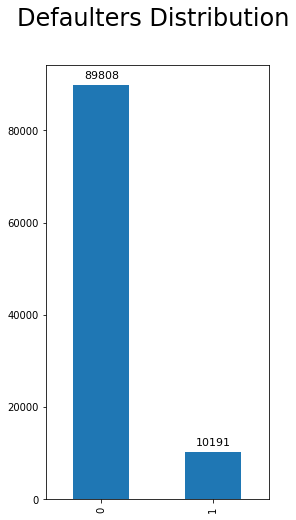

In [111]:
fig = plt.figure(figsize=(4,8))
fig.suptitle('Defaulters Distribution', fontsize=24)
ax = cust[DEPENDENT_VARIABLE].value_counts().plot.bar()
for p in ax.patches: 
    ax.annotate("%0.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11,  xytext=(0, 10), textcoords='offset points')


## Univariate analysis

### Continuous Features - Univariate & Segmented Univariate Analysis

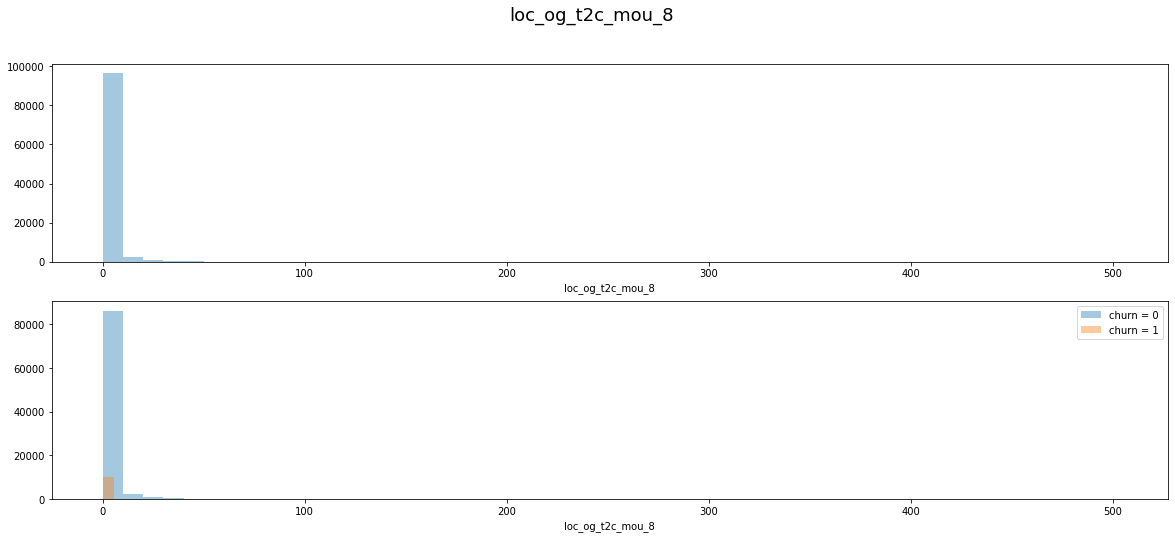

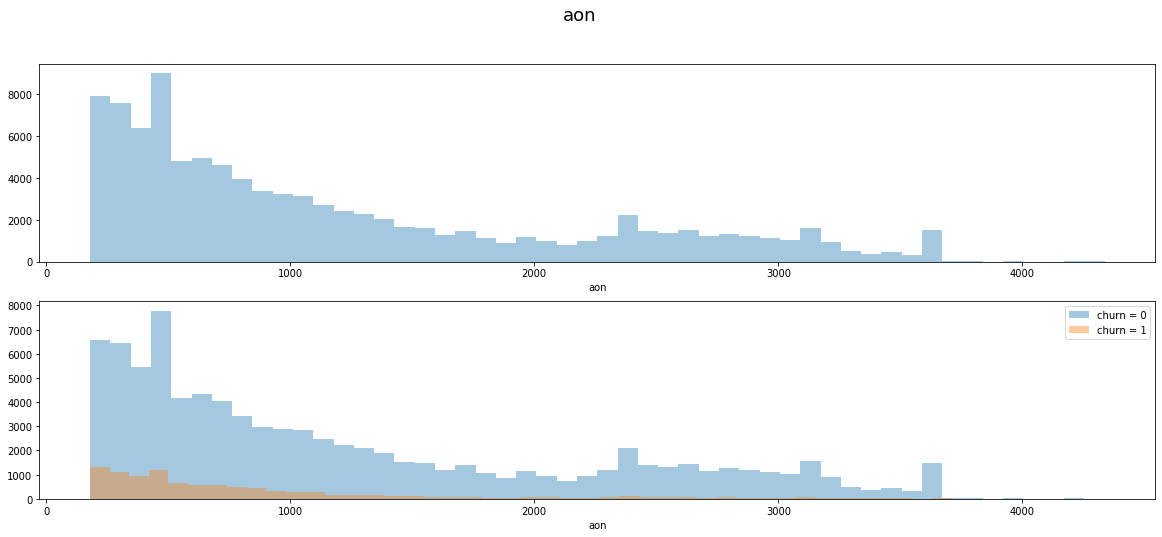

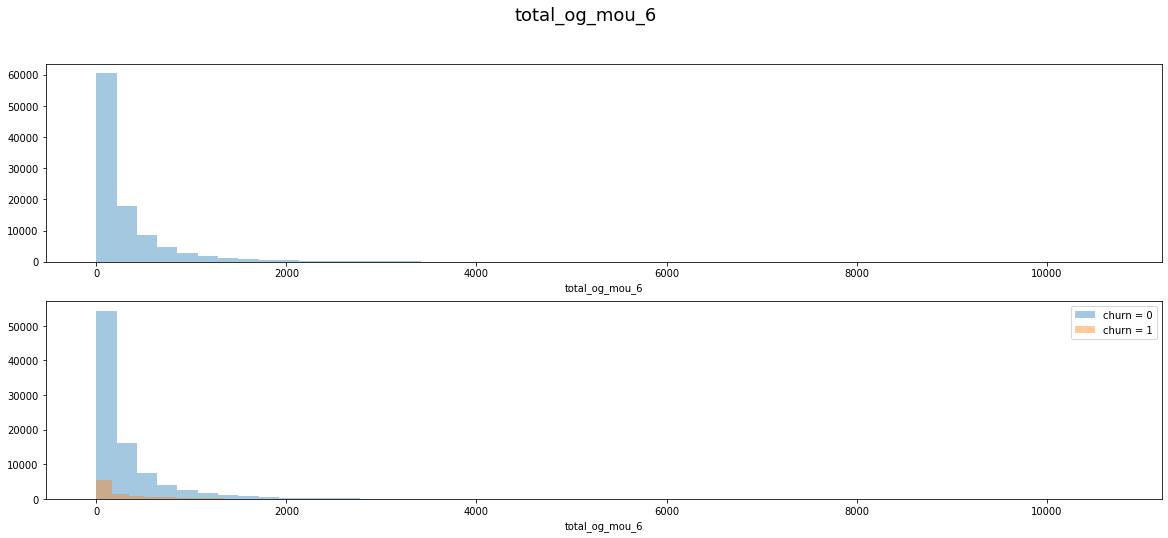

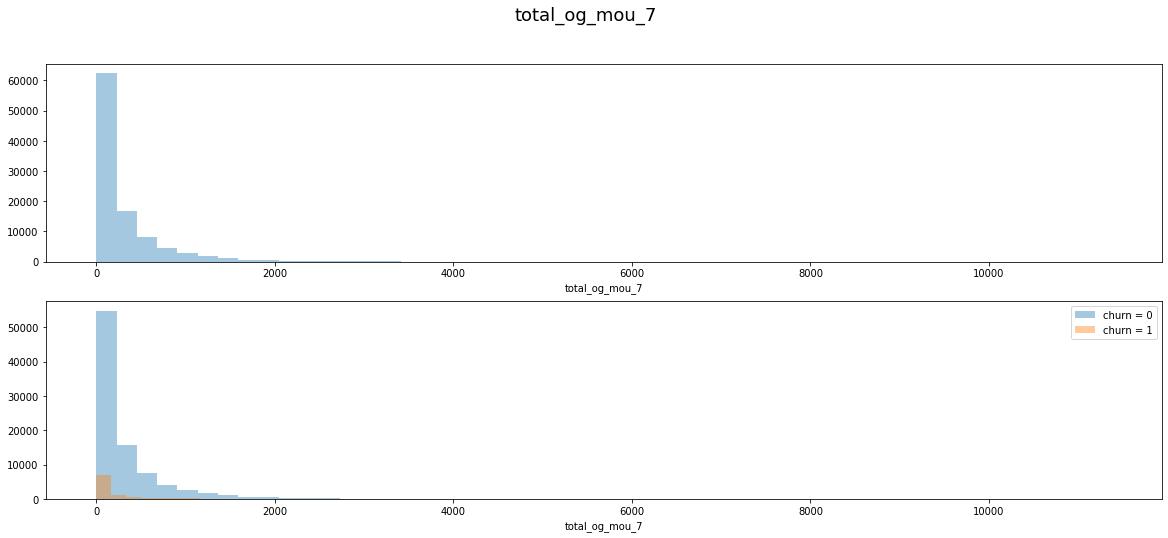

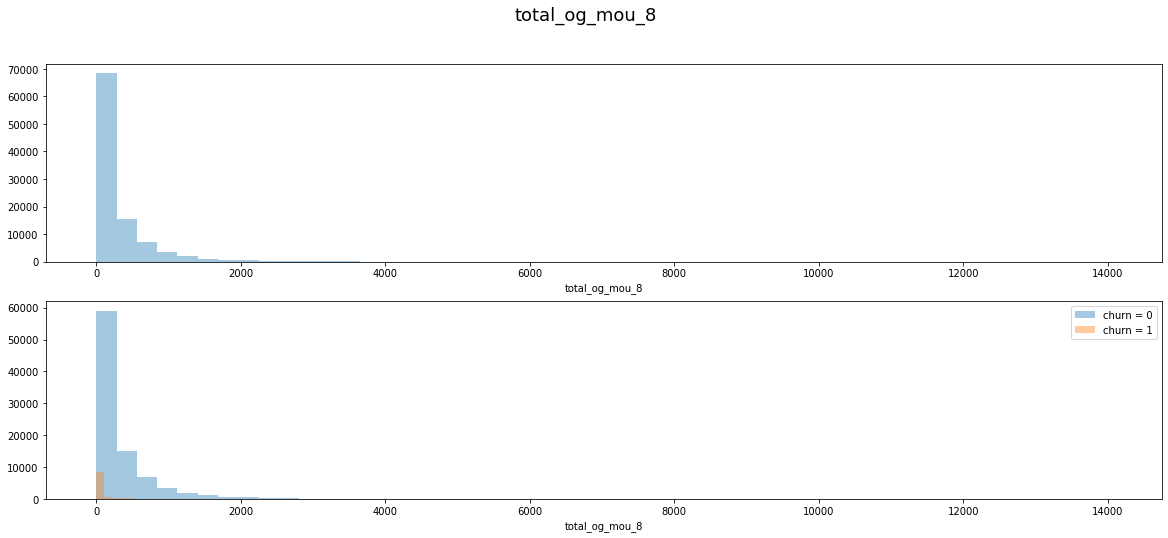

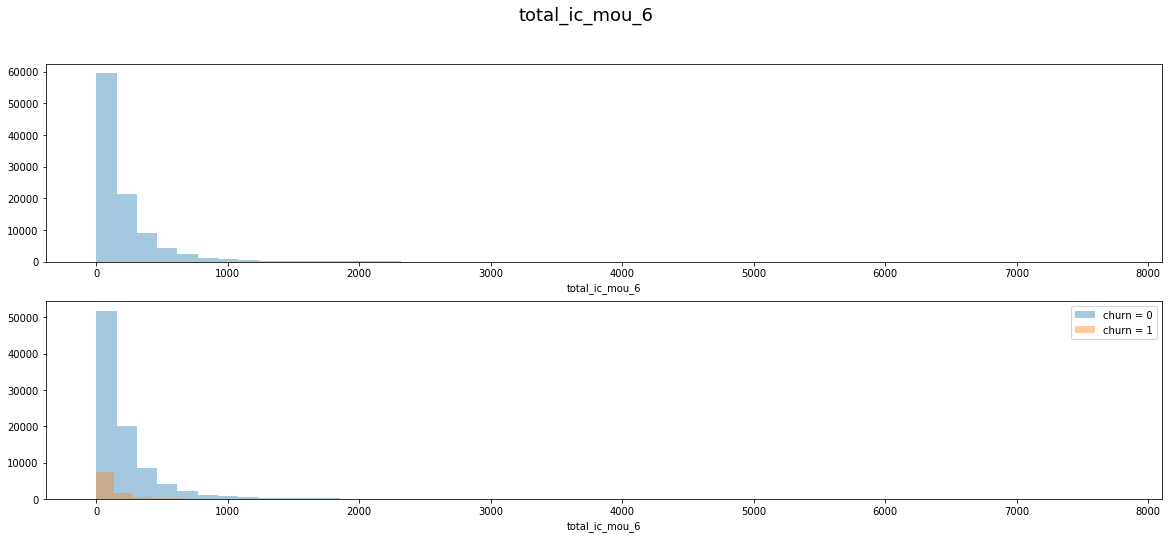

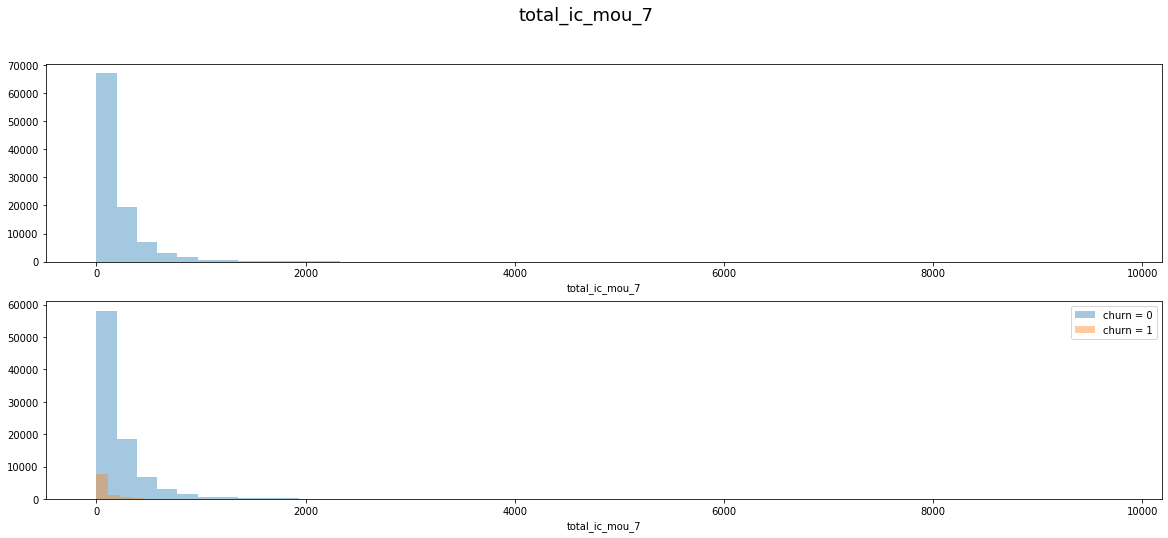

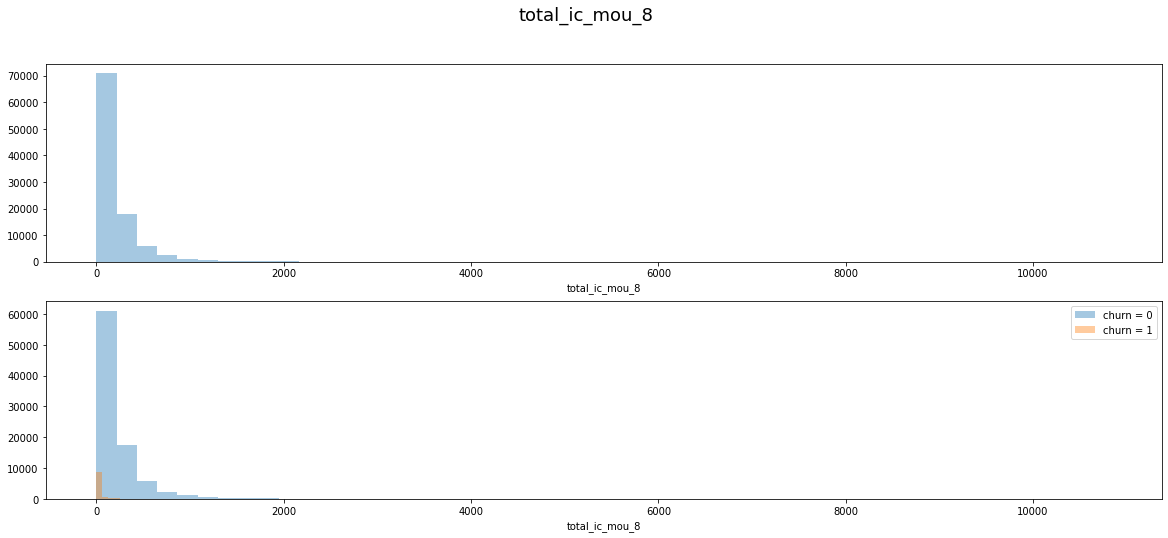

In [52]:

# For each continuous variable, plot
# a. Distribution plot for each continuous variable - Univariate Analysis
# b. Distribution plot against the target variable - Segmented Univariate Analysis
for col in CONTINUOUS_VAR_TO_ANALYSE:
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    fig.suptitle(col, fontsize=18)
    sns.distplot(cust[col], kde=False, ax=ax[0])
    for i in sorted(cust[DEPENDENT_VARIABLE].unique()):
        sns.distplot(cust[cust[DEPENDENT_VARIABLE] == i][col], kde=False, ax=ax[1], label=f'{DEPENDENT_VARIABLE} = {i}')
    ax[1].legend()

## Bivariate analysis

### Heat map/correlation matrix

In [53]:
df = cust[CONTINUOUS_VAR_TO_ANALYSE + ['churn']]
corr = df.corr() 

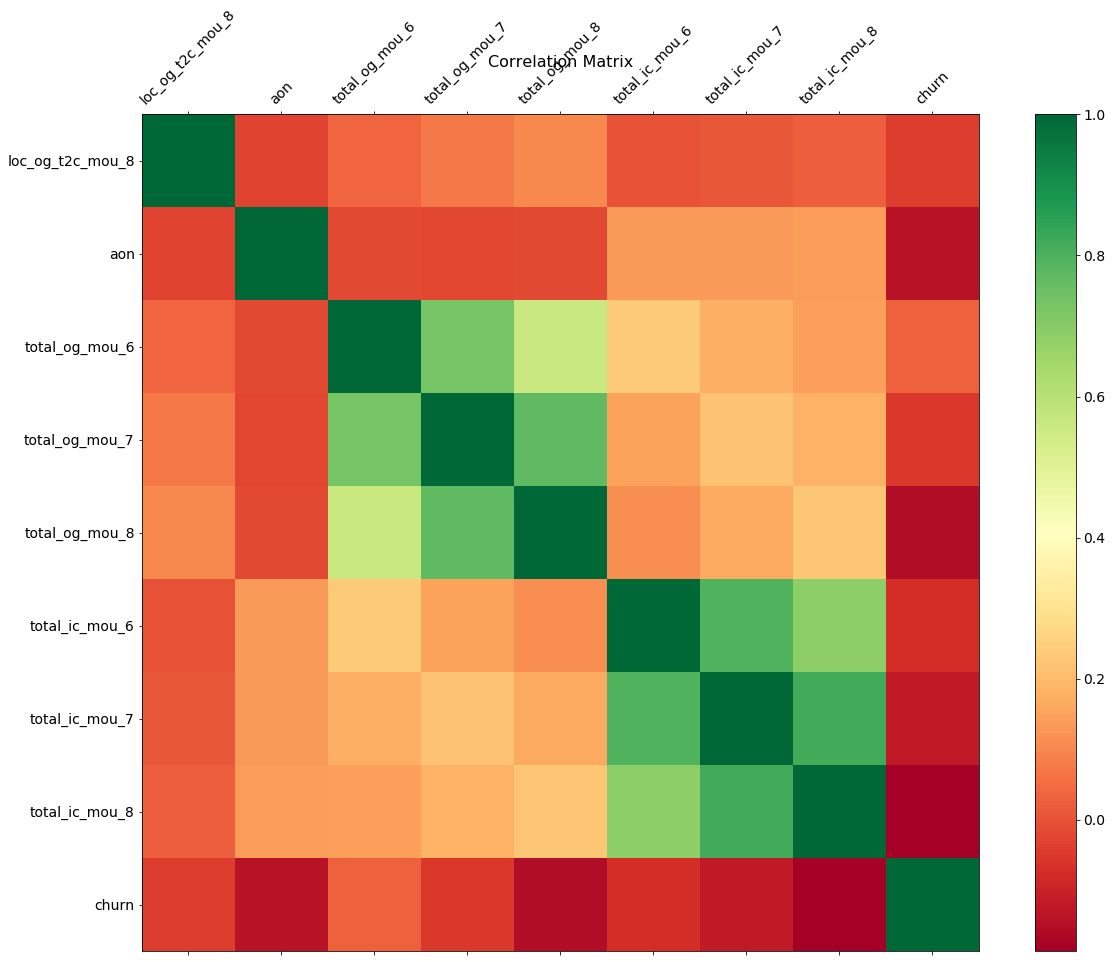

In [54]:
f = plt.figure(figsize=(20, 15))

ax = plt.matshow(corr, fignum=f.number,cmap='RdYlGn')
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#ax.set_ylim([0,2])
plt.title('Correlation Matrix', fontsize=16);

In [55]:

corr.style.background_gradient(cmap='coolwarm').set_precision(1)

,loc_og_t2c_mou_8,aon,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,churn
loc_og_t2c_mou_8,1,-0.03,0.04,0.07,0.1,0.003,0.01,0.03,-0.04
aon,-0.03,1,-0.02,-0.02,-0.02,0.1,0.1,0.1,-0.1
total_og_mou_6,0.04,-0.02,1,0.7,0.6,0.2,0.2,0.1,0.03
total_og_mou_7,0.07,-0.02,0.7,1,0.8,0.1,0.2,0.2,-0.05
total_og_mou_8,0.1,-0.02,0.6,0.8,1,0.1,0.2,0.2,-0.2
total_ic_mou_6,0.003,0.1,0.2,0.1,0.1,1,0.8,0.7,-0.07
total_ic_mou_7,0.01,0.1,0.2,0.2,0.2,0.8,1,0.8,-0.1
total_ic_mou_8,0.03,0.1,0.1,0.2,0.2,0.7,0.8,1,-0.2
churn,-0.04,-0.1,0.03,-0.05,-0.2,-0.07,-0.1,-0.2,1


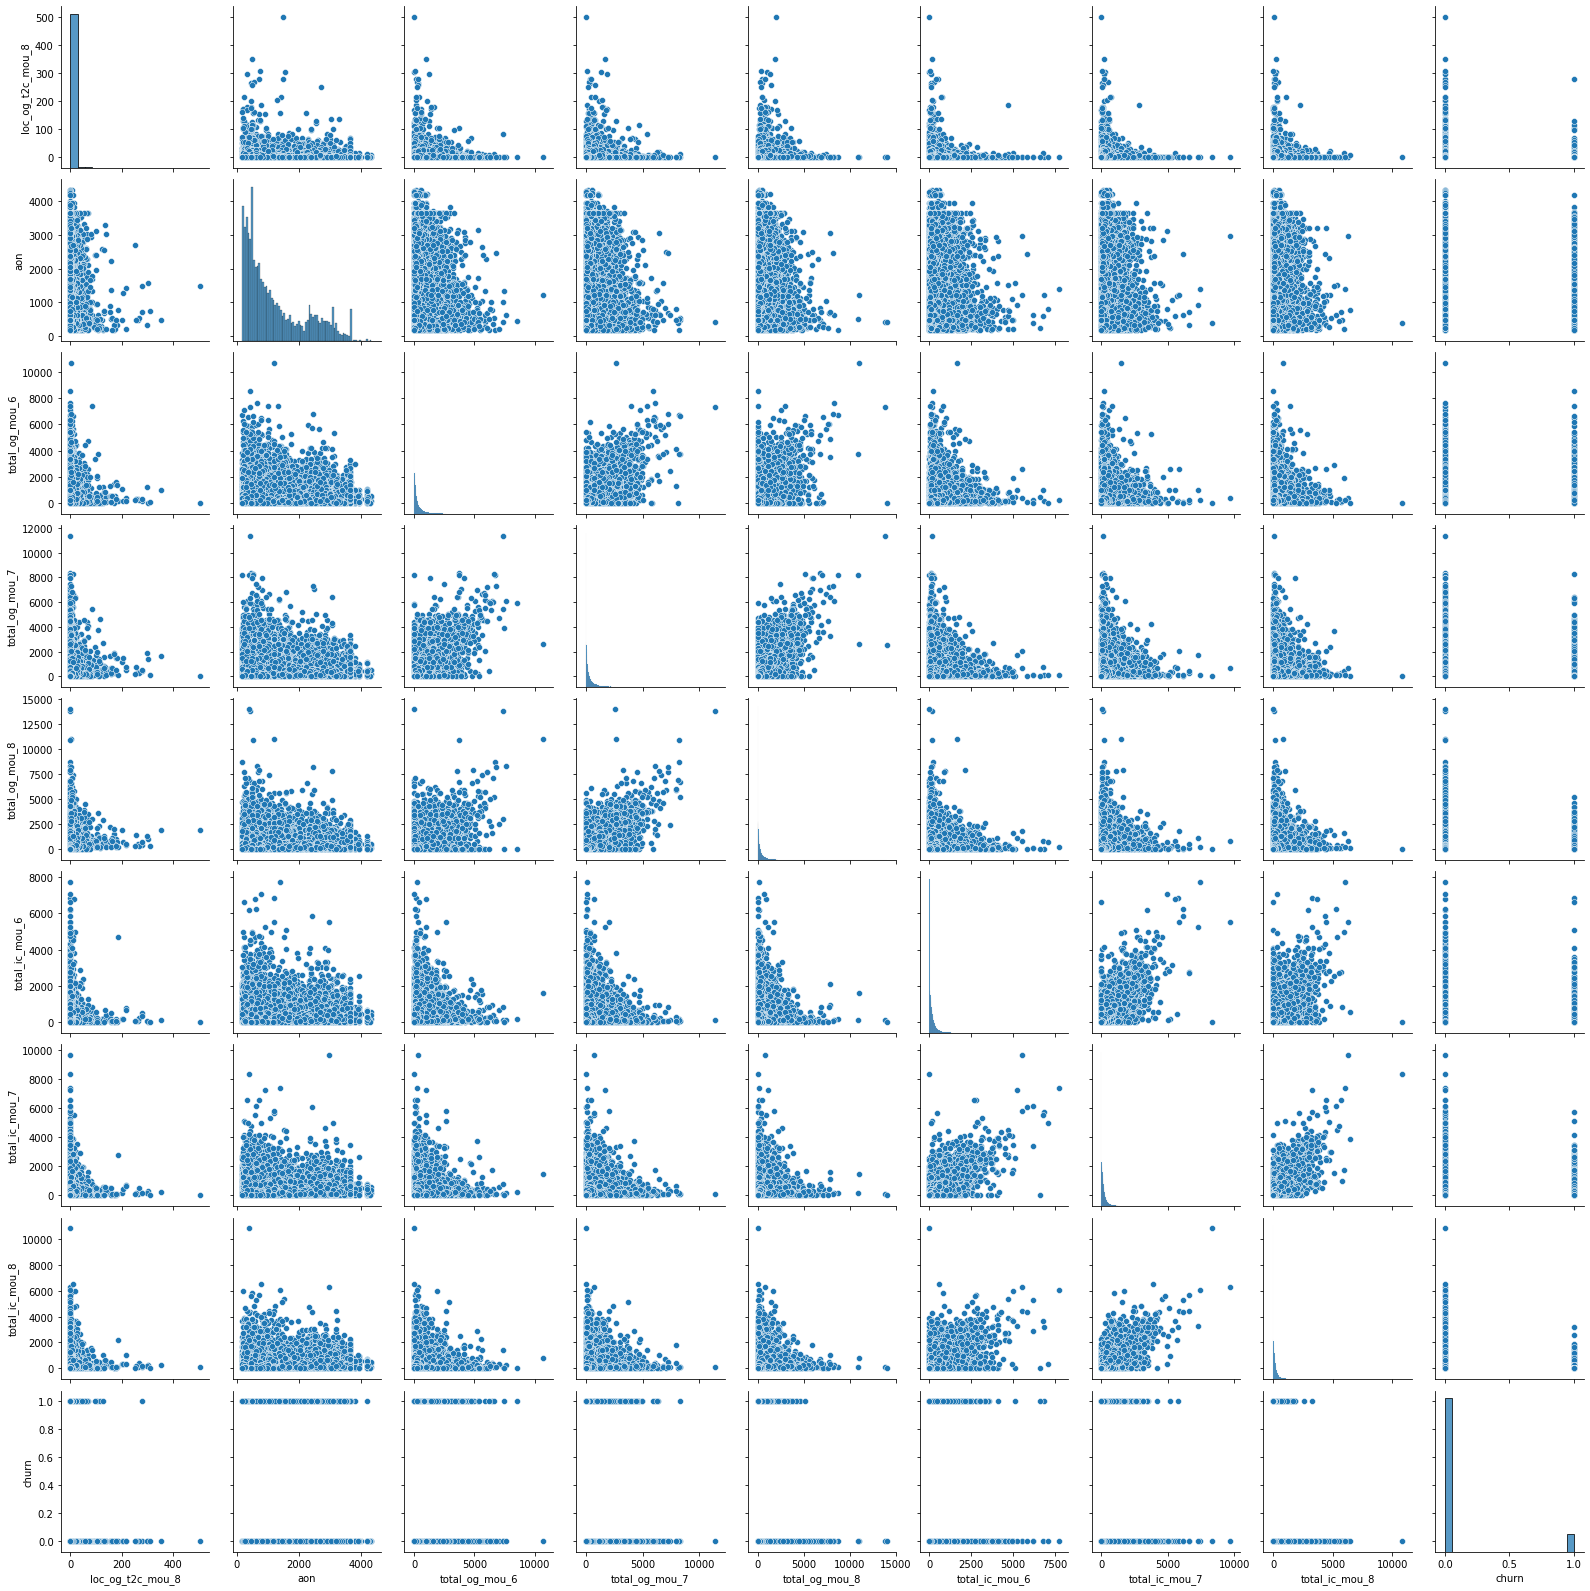

In [56]:
sns.pairplot(df)

<TODO> Insights:
    High correlation between 2 consecutive months (M6 & M7, M7 & M8).<br>
    Good correlation between alternate months (M6 & M8)<br>
--     Churn is negatively correlated to the calls made to the customer care (t2c). More calls to customer care implies more chances of churning.

# Derive new features

- Derive new feature on average usage in good & action phase 
- Derive new feature on usage during action phase vs good phase

In [57]:
# Method to create the derived features for the given column pattern
# 1. Creates two derived features - average of 3 months, good vs action phase
# 2. Drops the features from which the new columns were created to remove multicollinearity
def create_derived_avg_variables(pattern,col_prefix):
   # Create columns for the good phase & action phase
    gphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_6|_7]$', col)]
    aphase_cols = [col for col in cust.columns if re.match(f'{pattern}[_8]$', col)]

    # Get average for 3 months
    cust[f'{col_prefix}_avg'] = round((cust[gphase_cols].sum(axis=1)+cust[aphase_cols].sum(axis=1))/3,2)

    # Get the differece between action phase & average value in good phase
    # Hypothesis: If the values are in negative, it implies that the variable has reduced in the action phase as compared to an average in the good phase - more likely to churn
    cust[f'{col_prefix}_gaphase_avg'] = round(cust[aphase_cols].sum(axis=1) - (cust[gphase_cols].sum(axis=1))/2,2) 
    
    # Verify Values
    print('Sample data for cross-verification:')
    display(cust[gphase_cols + aphase_cols +[f'{col_prefix}_avg',f'{col_prefix}_gaphase_avg']].tail())
    
    # Drop monthly arpu related columns after creating the derived variables
    cust.drop(gphase_cols, axis=1, inplace=True)
    cust.drop(aphase_cols, axis=1, inplace=True)

In [58]:
cust.shape

(99999, 156)

## Derive based on ARPU (Average Revenue Per User)

In [59]:
create_derived_avg_variables('^arpu_.*','arpu')

Sample data for cross-verification:


,arpu_6,arpu_7,arpu_3g_6,arpu_3g_7,arpu_2g_6,arpu_2g_7,arpu_8,arpu_3g_8,arpu_2g_8,arpu_avg,arpu_gaphase_avg
99994,18.471,69.161,0.00,0.00,0.00,0.00,57.530,0.00,0.00,48.39,13.71
99995,112.201,77.811,0.00,0.00,0.00,0.00,79.081,0.00,0.00,89.70,-15.92
99996,229.187,0.000,141.48,0.00,2.40,0.00,0.000,0.00,0.00,124.36,-186.53
99997,322.991,303.386,235.68,301.34,235.68,301.34,606.817,602.68,602.68,1170.86,961.97
99998,687.065,0.000,11.40,0.00,18.68,0.00,0.000,0.00,0.00,239.05,-358.57


In [60]:
# # Create columns for the good phase & action phase
# arpu_gphase_cols = [col for col in cust.columns if re.match('^arpu_.*[_6|_7]$', col)]
# arpu_aphase_cols = [col for col in cust.columns if re.match('^arpu_.*[_8]$', col)]

# # Get average arpu for 3 months
# cust['arpu_avg'] = round((cust[arpu_gphase_cols].sum(axis=1)+cust[arpu_aphase_cols].sum(axis=1))/3,2)

# # Get the differece in arpu between action phase & average value in good phase
# # Hypothesis: If the values are in negative, it implaces that the arpu has reduced in the action phase as compared to an average in the good phase  (more likely to churn)
# cust['arpu_gaphase_avg'] = round(cust[arpu_aphase_cols].sum(axis=1) - (cust[arpu_gphase_cols].sum(axis=1))/2,2)

In [61]:
# # Verify Values
# cust[arpu_gphase_cols + arpu_aphase_cols +['arpu_avg','arpu_gaphase_avg']].tail()

In [62]:
# # Drop monthly arpu related columns after creating the derived variables
# cust.drop(arpu_gphase_cols, axis=1, inplace=True)
# cust.drop(arpu_aphase_cols, axis=1, inplace=True)

In [63]:
# cust.shape

## Derive based on total MOU (Minutes of Usage)

In [64]:
create_derived_avg_variables('^total.*mou_','total_mou')

Sample data for cross-verification:


,total_og_mou_6,total_og_mou_7,total_ic_mou_6,total_ic_mou_7,total_og_mou_8,total_ic_mou_8,total_mou_avg,total_mou_gaphase_avg
99994,20.59,60.84,93.09,72.88,58.71,160.83,155.65,95.84
99995,130.09,87.14,56.11,81.38,82.46,67.81,168.33,-27.09
99996,25.14,0.00,473.69,0.00,0.00,0.00,166.28,-249.42
99997,0.00,0.00,0.81,11.09,0.00,2.29,4.73,-3.66
99998,269.93,0.00,788.73,0.00,0.00,0.00,352.89,-529.33


## Derive based on volume of data usage

In [65]:
create_derived_avg_variables('^vol_.*','vol')

Sample data for cross-verification:


,vol_2g_mb_6,vol_2g_mb_7,vol_3g_mb_6,vol_3g_mb_7,vol_2g_mb_8,vol_3g_mb_8,vol_avg,vol_gaphase_avg
99994,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
99995,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
99996,0.21,0.00,275.85,0.00,0.00,0.0,92.02,-138.03
99997,76.51,241.77,1453.63,1382.08,136.47,2683.3,1991.25,1242.78
99998,26.11,0.00,152.70,0.00,0.00,0.0,59.60,-89.40


In [66]:
## Derive based on volume of data usage

In [67]:
## Derive based on volume of data usage

In [68]:
## Derive based on volume of data usage

In [69]:
## Derive based on volume of data usage

In [70]:
# # Create columns for the good phase & action phase
# mou_gphase_cols = [col for col in cust.columns if re.match('^total.*mou_[_6|_7]$', col)]
# mou_aphase_cols = [col for col in cust.columns if re.match('^total.*mou_[_8]$', col)]

# # Get average for 3 months
# cust['mou_avg'] = round((cust[mou_gphase_cols].sum(axis=1)+cust[mou_aphase_cols].sum(axis=1))/3,2)

# # Get the differece between action phase & average value in good phase
# # Hypothesis: If the values are in negative, it implaces that the mou has reduced in the action phase as compared to an average in the good phase (more likely to churn)
# cust['mou_gaphase_avg'] = round(cust[mou_aphase_cols].sum(axis=1) - (cust[mou_gphase_cols].sum(axis=1))/2,2)

In [71]:
# Verify Values
# display(cust[mou_gphase_cols + mou_aphase_cols +['mou_avg','mou_gaphase_avg']].tail())

In [72]:
# # Drop monthly arpu related columns after creating the derived variables
# cust.drop(mou_gphase_cols, axis=1, inplace=True)
# cust.drop(mou_aphase_cols, axis=1, inplace=True)

In [73]:
# cust.shape

# Split data to independent & dependent variables

In [160]:
X = cust.drop([DEPENDENT_VARIABLE],axis=1)
y = cust[DEPENDENT_VARIABLE]

# Handle class imbalance

In [161]:
cust['churn'].value_counts()

0    89808
1    10191
Name: churn, dtype: int64

In the given dataset, churn vs non-churn is at 10%-90%. <br>
This is a case of class imbalance where one class outnumbers the other. <br>
We can apply some of the class imbalance techniques to address this issue and observe how the models behave <br>
In this case study we shall use the oversampling & SMOTE techniques to address the class imbalance issue

## Oversampling

In [162]:
# import library
from imblearn.over_sampling import RandomOverSampler

over_sampler = RandomOverSampler(random_state=42)

# fit predictor and target variablex_ros, 
X_oversampled, y_oversampled = over_sampler.fit_resample(X,y)


print(f'''Shape of X before oversampling: {X.shape}
Shape of X after oversampling: {X_oversampled.shape}''')

print('\nBalance of positive and negative classes (%):')
y_oversampled['churn'].value_counts(normalize=True) * 100



Shape of X before oversampling: (99999, 140)
Shape of X after oversampling: (179616, 140)

Balance of positive and negative classes (%):


KeyError: 'churn'

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_smote.shape}''')

print('\nBalance of positive and negative classes (%):')
y_smote['churn'].value_counts(normalize=True) * 100

# Train-test split

## Train-test split on original data (without oversampling or SMOTE)

In [163]:
# 70% of data used as train data and the remaining 30% as test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=100)

## Train-test split on oversampled data 


In [164]:
# 70% of data used as train data and the remaining 30% as test data
X_oversampled_train, X_oversampled_test, y_oversampled_train, y_oversampled_test = train_test_split(X_oversampled,y_oversampled,test_size = 0.3, random_state=100)

## Train-test split on SMOTE data 


In [165]:
# 70% of data used as train data and the remaining 30% as test data
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote,y_smote,test_size = 0.3, random_state=100)

# Feature Scaling

In [166]:
cols_to_scale = X_train.columns

In [167]:
# Scale the original dataset
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale] )

In [168]:
# Scale the oversampled dataset
scaler_os = MinMaxScaler()
X_oversampled_train[cols_to_scale] = scaler_os.fit_transform(X_oversampled_train[cols_to_scale])
X_oversampled_test[cols_to_scale] = scaler_os.transform(X_oversampled_test[cols_to_scale])

In [169]:
# Scale the SMOTE dataset
scaler_smote = MinMaxScaler()
X_smote_train[cols_to_scale] = scaler_smote.fit_transform(X_smote_train[cols_to_scale])
X_smote_test[cols_to_scale] = scaler_smote.transform(X_smote_test[cols_to_scale])

In [170]:
X_train.describe()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,sep_vbc_3g,last_rech_num_days,avg_rech_amt_6_7,is_hvc,arpu_avg,arpu_gaphase_avg,total_mou_avg,total_mou_gaphase_avg,vol_avg,vol_gaphase_avg
count,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000
mean,0.018122,0.015962,0.011616,0.022738,0.022792,0.024932,0.003561,0.001602,0.001602,0.004222,...,0.001764,0.077579,0.007935,0.300776,0.019878,0.415087,0.053791,0.557752,0.005230,0.476902
std,0.041788,0.037656,0.027869,0.037682,0.038997,0.042666,0.020893,0.012736,0.012547,0.021968,...,0.017115,0.115762,0.014299,0.458599,0.024518,0.014262,0.057982,0.032226,0.015937,0.015634
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000767,0.000593,0.000375,0.003416,0.003218,0.003186,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.010870,0.002090,0.000000,0.006206,0.410755,0.017078,0.548825,0.000000,0.476559
50%,0.004406,0.003611,0.002591,0.010702,0.010234,0.011143,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.043478,0.004491,0.000000,0.012758,0.414746,0.036036,0.557936,0.000000,0.476559
75%,0.016030,0.013597,0.009819,0.026543,0.026108,0.028879,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.076087,0.009063,1.000000,0.024503,0.418875,0.070046,0.566266,0.002558,0.476559
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Helper functions - to compute the evaluation metrics

In [225]:
# Compute classification accuracy: percentage of correct predictions
def get_accuracy(Y_test, Y_predict):
    accuracy_score_value = accuracy_score(Y_test, Y_predict)
    return accuracy_score_value
        
# Compute the confusion metrics
def get_confusion_matrix(Y_test, Y_predict, labels):
    from sklearn.metrics import confusion_matrix

    conf_matrix = pd.DataFrame(confusion_matrix(Y_test, Y_predict, labels=labels), columns=labels, index=labels)
    conf_matrix_df = conf_matrix.add_prefix('Predicted ')
    conf_matrix_df.index = ['Actual ' + str(row_name) for row_name in conf_matrix_df.index]
    return conf_matrix_df, conf_matrix

# Compute null accuracy
def get_null_accuracy(Y_test, multiclass):
    # Null accuracy: accuracy that could be achieved by always predicting the most frequent class
    # Used as a reference as minimum accuracy to be achieved with the model
    null_accuracy = Y_test.value_counts().head(1) / len(Y_test)
    return null_accuracy.values[0]


def get_individual_values_from_confusion_matrix(conf_matrix):
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    import numpy as np
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.values.sum() - (FP + FN + TP)

    return FP, FN, TP, TN


# Sensitivity, hit rate, recall, or true positive rate
def get_sensitivity(TP, FN):
    return TP / (TP + FN)


# Specificity or true negative rate
def get_specificity(TN, FP):
    return TN / (TN + FP)


# Precision or positive predictive value
def get_precision(TP, FP):
    return TP / (TP + FP)


# F1-SCORE
def get_f1_score(precision, sensitivity):
    return 2 * ((precision * sensitivity) / (precision + sensitivity))


# Negative predictive value
def get_negative_predictive_value(TN, FN):
    return TN / (TN + FN)


# Fall out or false positive rate
def get_false_positive_rate(FP, TN):
    return FP / (FP + TN)


# False negative rate
def get_false_negative_rate(FN, TP):
    return FN / (TP + FN)


# False discovery rate
def get_false_discovery_rate(FP, TP):
    return FP / (TP + FP)


# Log loss
def get_log_loss(y_true, y_pred_proba):
    from sklearn.metrics import log_loss
    return log_loss(y_true, y_pred_proba, eps=1e-15)

# AUROC score
def get_roc_auc_score(Y_test,Y_predict):
    return roc_auc_score(Y_test,Y_predict)

def get_performance_measures(Y_test, Y_predict, labels):
    conf_matrix_df, conf_matrix = get_confusion_matrix(Y_test, Y_predict, labels)
    FP, FN, TP, TN = get_individual_values_from_confusion_matrix(conf_matrix)
    df = pd.DataFrame({
        'Accuracy': get_accuracy(Y_test,Y_predict),
        'Null Accuracy': get_null_accuracy(Y_test,Y_predict),
        'AUROC':get_roc_auc_score(Y_test,Y_predict),
        'Sensitivity': get_sensitivity(TP, FN),
        'Specificity': get_specificity(TN, FP),
        'Precision': get_precision(TP, FP),
        'F1 Score': get_f1_score(get_precision(TP, FP), get_sensitivity(TP, FN)),
        'Negative Predictive Value': get_negative_predictive_value(TN, FN),
        'False Positive Rate': get_false_positive_rate(FP, TN),
        'False Negative Rate': get_false_negative_rate(FN, TP),
        'False Discovery Rate': get_false_discovery_rate(FP, TP),
    })#.T.add_prefix('Class ')
    # Creates metrics for each label. Return details of only class 1 (customer churn)
    return (df.loc[1]*100).round(3)



In [226]:
#run_logistic_regression(X_train_pca, X_test_pca, y_train, y_test)

Accuracy                     91.177
Null Accuracy                89.827
AUROC                        61.327
Sensitivity                  23.853
Specificity                  98.801
Precision                    69.267
F1 Score                     35.486
Negative Predictive Value    91.972
False Positive Rate           1.199
False Negative Rate          76.147
False Discovery Rate         30.733
Name: 1, dtype: float64

# SET CONFIGURATIONS

## Set models to be run and compared

In [ ]:
# TODO
ALL_SUPPORTED_MODELS = ['LOGISTRIC_REGRESSION','DECISION_TREE','RANDOM_FOREST','GAUSSIAN NAIVE BAYES']

## Set the evaluation metric

In [ ]:
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'
SORT_ASCENDING = False

# Model building 1 - PCA

## PCA for dimensionality reduction

In [172]:
pca = PCA(random_state=42)
pca.fit(X_train)
pca.components_

array([[ 2.69642029e-02,  2.46098641e-02,  1.44518223e-02, ...,
        -7.35434994e-03,  1.28161540e-02, -1.62995249e-03],
       [ 2.58357677e-02,  2.50654792e-02,  1.77442063e-02, ...,
        -1.97164810e-04, -1.15264377e-02, -9.11376035e-04],
       [-8.15438321e-03, -8.68528745e-03, -6.18137644e-03, ...,
        -5.19241170e-04, -5.97711868e-04,  1.91186947e-04],
       ...,
       [ 0.00000000e+00,  5.71613008e-16, -8.81693672e-16, ...,
         7.18567888e-15, -2.32860416e-17, -1.42792311e-17],
       [-0.00000000e+00, -1.20881672e-15, -1.09936576e-15, ...,
        -7.45730076e-14, -9.68552508e-17,  3.68811533e-17],
       [-0.00000000e+00, -8.92830358e-16,  5.65804638e-15, ...,
         9.70962324e-14, -6.77621701e-16, -2.86365964e-16]])

In [173]:
pca.explained_variance_ratio_

array([4.43681060e-01, 1.77546811e-01, 1.08088138e-01, 3.75948117e-02,
       2.99015274e-02, 2.50680077e-02, 1.95551414e-02, 1.58915892e-02,
       1.30430648e-02, 1.19059052e-02, 9.53612869e-03, 6.74945045e-03,
       6.33749626e-03, 5.99211137e-03, 5.35006897e-03, 5.27549301e-03,
       4.47371180e-03, 4.16789734e-03, 3.62437534e-03, 3.43353661e-03,
       3.21143579e-03, 3.09092859e-03, 2.98353071e-03, 2.90524051e-03,
       2.67122192e-03, 2.61251415e-03, 2.41883977e-03, 2.32649463e-03,
       2.21145766e-03, 2.16390692e-03, 2.05193973e-03, 2.00247696e-03,
       1.91019081e-03, 1.77155013e-03, 1.62349658e-03, 1.54750044e-03,
       1.22491063e-03, 1.13028518e-03, 1.09616780e-03, 1.01114373e-03,
       9.70482671e-04, 9.10669817e-04, 8.51145907e-04, 8.25458732e-04,
       7.72585364e-04, 7.33070493e-04, 7.06414875e-04, 6.93298764e-04,
       6.72207804e-04, 6.43838386e-04, 6.27202794e-04, 5.74880976e-04,
       5.59771446e-04, 5.41508351e-04, 4.93676847e-04, 4.63683851e-04,
      

<BarContainer object of 30 artists>

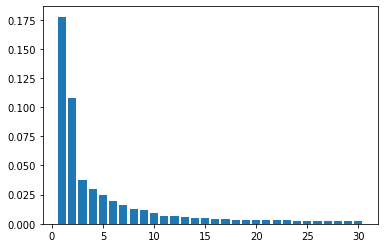

In [174]:
# plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.bar(range(1,31), pca.explained_variance_ratio_[1:31])

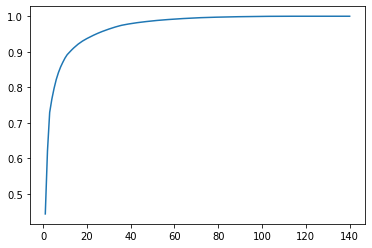

In [175]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

# Making the scree plot
plt.plot(range(1,len(var_cumu)+1), var_cumu)

In [176]:
pd.DataFrame(var_cumu).head(30)

,0
0,0.443681
1,0.621228
2,0.729316
3,0.766911
4,0.796812
5,0.821880
6,0.841435
7,0.857327
8,0.870370
9,0.882276


- 94% of the variance is explained by the first 20 Principal Components <br>
- We can try running models with 20 components and check how they perform

## Create PCA datasets

In [177]:
num_pcs = 20

In [178]:
# Get the top 20 principal components 
pcs = IncrementalPCA(n_components=num_pcs)

In [179]:
# Utility method to create the new principal component datasets on the train & test data
def create_pca_data(train,test):
    train_pca = pd.DataFrame(pcs.fit_transform(train)).add_prefix('PC')
    # Index is lost after PCA as it works on Numpy arrays. 
    # Ref: https://github.com/scikit-learn/scikit-learn/issues/8238
    train_pca.index = train.index
    print(f'Train PCA data shape:{train_pca.shape}')
    display(train_pca.head(3))

    test_pca = pd.DataFrame(pcs.transform(test)).add_prefix('PC')
    test_pca.index = test.index
    print(f'Test PCA data shape:{test_pca.shape}')
    display(test_pca.head(3))
    
    
    
    return train_pca, test_pca
    

In [180]:
# Create PCA dataset for the original dataset
X_train_pca, X_test_pca = create_pca_data(X_train,X_test)

Train PCA data shape:(69999, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
71946,-0.320617,0.033849,-0.232182,-0.021312,0.092704,0.040094,-0.017597,-0.001768,-0.031494,-0.000673,-0.010268,-0.007126,0.012772,0.011454,0.003879,-0.011368,-0.007349,-0.006929,0.005685,0.007015
21641,-0.385777,-1.121833,0.428030,-0.038583,0.075581,-0.154644,0.008294,-0.036430,0.005145,-0.062053,0.037804,-0.030291,-0.052131,-0.072500,0.045467,-0.000755,-0.011039,-0.037600,0.022321,-0.009412
82641,-0.335140,0.024037,0.520534,-0.015633,0.301571,0.231168,-0.038666,-0.051996,0.080841,-0.005241,-0.013926,-0.003596,0.008711,-0.026754,-0.008878,0.023834,-0.015538,-0.009514,-0.007892,0.014106


Test PCA data shape:(30000, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
79667,-0.240942,0.281806,-0.126462,-0.108722,0.059803,-0.275864,0.311081,-0.113930,0.107438,0.049722,0.026765,0.030891,-0.044490,-0.048256,-0.003077,0.019087,0.020412,-0.021934,0.053066,-0.013131
83841,0.712317,0.205989,-0.151177,-0.112243,0.290913,-0.040930,0.078656,-0.032781,0.057557,0.128440,0.005806,0.003668,0.003507,-0.061199,0.031788,-0.023566,-0.116841,-0.000706,0.046450,-0.011917
57025,-0.315584,0.028398,-0.087976,-0.007128,0.016197,-0.022728,-0.027939,-0.012713,-0.057251,-0.013019,-0.007995,-0.005899,0.009529,0.031901,0.008069,-0.029876,0.006187,0.014356,0.000829,-0.007476


In [181]:
# Create PCA dataset for the oversampled dataset
X_oversampled_train_pca, X_oversampled_test_pca = create_pca_data(X_oversampled_train,X_oversampled_test)

Train PCA data shape:(125731, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
19207,0.694928,-1.160954,0.061701,0.034372,-0.019832,-0.091326,-0.072363,-0.007046,0.138248,-0.031884,0.078086,0.036409,-0.013328,-0.074537,0.014166,-0.041481,-0.017721,-0.013870,-0.032951,0.037901
79664,-0.259412,0.217063,0.027172,-0.149729,-0.034983,-0.039805,-0.089499,-0.039911,0.075265,0.012378,-0.001727,-0.020422,0.005696,-0.034114,-0.023009,-0.001098,0.026594,0.014706,0.024321,-0.037762
138515,0.708853,0.216409,-0.192680,0.366594,-0.050194,-0.131946,0.019601,-0.036538,0.029049,0.171328,-0.019396,0.039317,0.039939,-0.006469,-0.193838,-0.031138,0.017417,0.013696,0.010021,-0.059589


Test PCA data shape:(53885, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
34540,-0.260966,-0.011701,0.514559,-0.158929,0.022181,0.025242,-0.047949,-0.023353,0.018326,0.003417,-0.015262,0.013009,0.004078,0.062432,-0.000441,0.021115,-0.021697,0.003174,0.004928,-0.009492
84960,0.796975,0.162834,0.099809,-0.113976,-0.029334,0.074567,0.109067,-0.157840,0.104884,-0.048847,-0.083427,-0.135167,-0.007245,0.017986,-0.018525,-0.136117,0.051193,-0.020403,-0.033190,0.015382
65999,-0.278191,0.004927,-0.119762,-0.141458,-0.004924,-0.017406,-0.034233,0.000945,0.005825,-0.027708,0.006208,0.072216,0.007154,0.003144,-0.011787,-0.015022,-0.032424,0.005268,0.019764,0.010245


In [182]:
# Create PCA dataset for the SMOTE dataset
X_smote_train_pca, X_smote_test_pca = create_pca_data(X_smote_train,X_smote_test)

Train PCA data shape:(125731, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
19207,0.721597,-1.160825,0.045136,0.052384,-0.019532,-0.117399,-0.073063,-0.001407,0.139093,0.064623,-0.050651,0.019335,-0.016411,-0.066882,-0.022982,-0.045737,-0.018788,-0.029210,-0.069884,-0.002906
79664,-0.234447,0.212889,0.025746,-0.151662,-0.036993,-0.042332,-0.089961,-0.049745,0.069258,0.003735,0.016338,-0.012093,0.008070,-0.035453,-0.013204,0.028012,0.022429,0.024783,0.042686,0.011807
138515,-0.254393,0.013409,-0.192237,0.130648,0.014075,0.106496,0.003785,0.012594,0.056964,0.035545,-0.013192,-0.004759,0.003466,0.085157,0.034041,0.012192,0.052797,-0.031225,0.033150,-0.020616


Test PCA data shape:(53885, 20)


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
34540,-0.233553,-0.024676,0.509403,-0.181935,0.018926,0.019815,-0.049207,-0.029000,0.012451,-0.013292,0.001336,0.013215,0.004388,0.057986,0.025427,0.007987,-0.023179,0.012404,-0.002276,0.008100
84960,0.823039,0.159133,0.095713,-0.113758,-0.027798,0.072644,0.115273,-0.141383,0.111206,-0.081836,0.030717,-0.139988,-0.007488,0.029119,-0.141303,-0.031195,0.010504,-0.019430,-0.015002,0.001927
65999,-0.253585,0.002093,-0.123191,-0.136117,-0.005519,-0.022702,-0.031547,-0.002752,0.005920,-0.005708,-0.053259,0.060281,0.004864,-0.001918,-0.006150,-0.003308,-0.042085,0.018086,-0.018506,0.014403


## Check for multicollinearity - PCA

Verify that the features (Principal Components) created from PCA are not correlated to each other

In [183]:
corrmat = np.corrcoef(X_train_pca.transpose())
corrmat.shape

(20, 20)

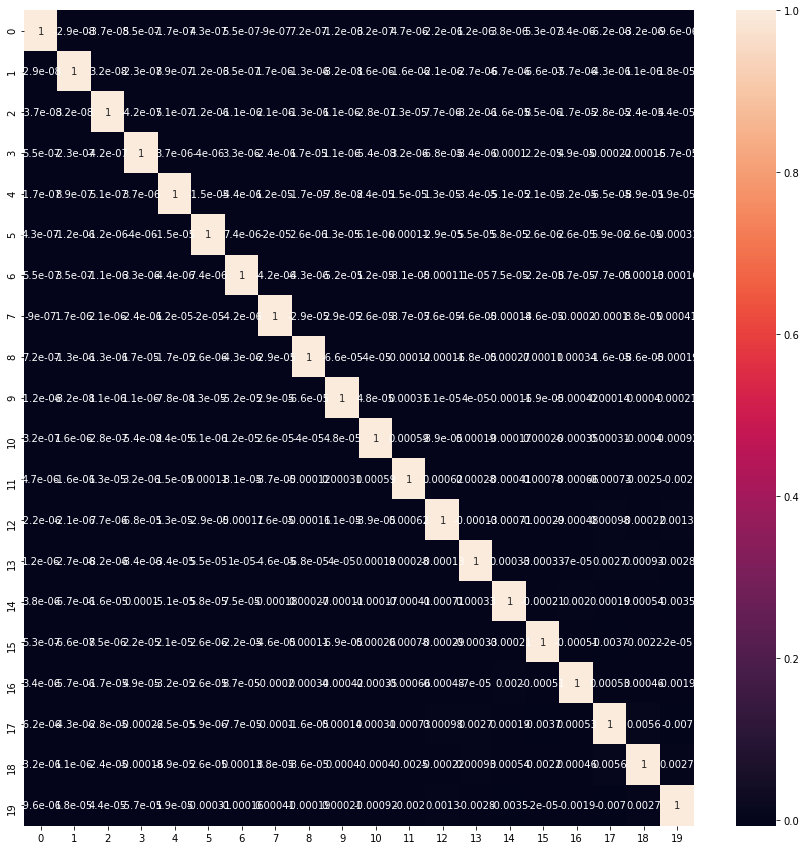

In [184]:
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

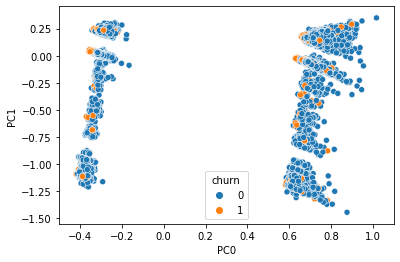

In [187]:
# Plotting the data of PC0 vs PC1
df_final = pd.concat([X_train_pca, y_train], axis=1)
sns.scatterplot(data=df_final, x="PC0", y="PC1",hue="churn")


## Model building - PCA

### Default Model Building

1. 8 models? <br>
2. Evaluate on train & test data <br>
3. Fill metrics - Accuracy, Precision, Recall, F1-score, AUROC?

In [188]:
labels = list(set(y_test))

In [ ]:
EVALUATION_METRIC = 'F1 Score' #'Accuracy','AUROC','Sensitivity','Specificity','Precision'


In [239]:
def model_fit_predict(model,X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_performance_measures(Y_test = y_test, Y_predict = y_pred, labels = labels)

In [278]:
model_result = pd.DataFrame()

In [279]:
def print_elapsed_time(end_time,start_time):
    total_time = end_time - start_time
    print(f'Elapsed time: {total_time//60} min {round(total_time - total_time//60,3)} sec')
    
    

In [284]:
def run_all_models(X_train, X_test, y_train, y_test,model_type):
    
    start_time = time.time()
    # Logistic Regression
    print(f'\nRunning Model: Logistic Regression')
    model_start_time = time.time()
    model_result[f'{model_type}-LR'] = model_fit_predict(LogisticRegression(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # Decision Tree Classifier
    print(f'\nRunning Model: Decision Tree Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-DCART'] = model_fit_predict(DecisionTreeClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # Random Forest Classifier 
    print(f'\nRunning Model: Random Forest Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-RF'] = model_fit_predict(RandomForestClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # Naive Bayes Classifier
    print(f'\nRunning Model: Naive Bayes Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-NB'] = model_fit_predict(GaussianNB(),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # Gradient Boost Classifier
    print(f'\nRunning Model: Gradient Boost Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-GB'] = model_fit_predict(GradientBoostingClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # XGBoost Classifier
    print(f'\nRunning Model: XGBoost Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-XGB'] = model_fit_predict(XGBClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # SVM Classifier
    print(f'\nRunning Model: SVM Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-SVC'] = model_fit_predict(SVC(probability=True,random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # K-Nearest Neighbors Classifier
    print(f'\nRunning Model: K-Nearest Neighbors Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-KNN'] = model_fit_predict(KNeighborsClassifier(),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # AdaBoost Classifier
    print(f'\nRunning Model: AdaBoost Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-ABC'] = model_fit_predict(AdaBoostClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    # MLP Classifier
    print(f'\nRunning Model: MLP Classifier')
    model_start_time = time.time()
    model_result[f'{model_type}-MLP'] = model_fit_predict(MLPClassifier(random_state=42),X_train, X_test, y_train, y_test)
    print_elapsed_time(time.time(),model_start_time)
    
    print('\nCOMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!')
    print_elapsed_time(time.time(),start_time)
    
    return model_result.T

In [285]:

model_results = run_all_models(X_train_pca, X_test_pca, y_train, y_test,'PCA - default')


EVALUATION_METRIC = "F1 Score"
SORT_ASCENDING = False
model_results.sort_values(by=EVALUATION_METRIC,ascending=SORT_ASCENDING)


Running Model: Logistic Regression
Elapsed time: 0.0 min 0.6 sec

Running Model: Decision Tree Classifier
Elapsed time: 0.0 min 2.221 sec

Running Model: Random Forest Classifier
Elapsed time: 0.0 min 28.853 sec

Running Model: Naive Bayes Classifier
Elapsed time: 0.0 min 0.079 sec

Running Model: Gradient Boost Classifier
Elapsed time: 0.0 min 42.588 sec

Running Model: XGBoost Classifier
Elapsed time: 0.0 min 11.169 sec

Running Model: SVM Classifier
Elapsed time: 63.0 min 3765.219 sec

Running Model: K-Nearest Neighbors Classifier
Elapsed time: 3.0 min 197.144 sec

Running Model: AdaBoost Classifier
Elapsed time: 0.0 min 11.886 sec

Running Model: MLP Classifier
Elapsed time: 5.0 min 300.5 sec

COMPLETED RUNNING ALL THE MODELS SUCCESSFULLY!!
Elapsed time: 73.0 min 4358.261 sec


,Accuracy,Null Accuracy,AUROC,Sensitivity,Specificity,Precision,F1 Score,Negative Predictive Value,False Positive Rate,False Negative Rate,False Discovery Rate
PCA - default-MLP,92.637,89.827,73.573,49.640,97.506,69.273,57.835,94.474,2.494,50.360,30.727
PCA - default-RF,91.893,89.827,67.159,36.107,98.211,69.571,47.541,93.138,1.789,63.893,30.429
PCA - default-KNN,90.987,89.827,66.727,36.271,97.183,59.325,45.018,93.087,2.817,63.729,40.675
PCA - default-GB,91.660,89.827,65.388,32.405,98.371,69.258,44.152,92.780,1.629,67.595,30.742
PCA - default-XGB,91.487,89.827,63.999,29.489,98.508,69.124,41.341,92.501,1.492,70.511,30.876
PCA - default-DCART,87.797,89.827,67.509,42.038,92.979,40.409,41.208,93.405,7.021,57.962,59.591
PCA - default-NB,88.810,89.827,66.460,38.401,94.519,44.243,41.116,93.126,5.481,61.599,55.757
PCA - default-ABC,90.997,89.827,64.118,30.374,97.863,61.677,40.703,92.543,2.137,69.626,38.323
PCA - default-LR,91.177,89.827,61.327,23.853,98.801,69.267,35.486,91.972,1.199,76.147,30.733
PCA - default-SVC,91.080,89.827,58.324,17.202,99.447,77.893,28.180,91.383,0.553,82.798,22.107


### Model building with HPT

### Model on oversampled data

In [ ]:
model_results = run_all_models(X_oversampled_train_pca, X_oversampled_test_pca, y_oversampled_train, y_oversampled_test,'PCA - Oversampled')


### Model on SMOTE data

In [ ]:
model_results = run_all_models(X_smote_train_pca, X_smote_test_pca, y_smote_train, y_smote_test,'PCA - SMOTE')

### Model on (SMOTE + HPT)

# Model building 2 - without PCA

# Insights

## Best Model - with PCA

Finally, choose a model based on some evaluation metric.

## Important features

After identifying important predictors, display them visually - you can use plots, summary tables etc. - whatever you think best conveys the importance of features.

## Conclusion - recommendation to manage customer churn

Finally, recommend strategies to manage customer churn based on your observations.